In [5]:
import sqlite3
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data from sqlite

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/671_Final_Project_Data/yelp_dataset_business.db')
df_business= pd.read_sql("""SELECT * FROM business""",conn )
conn.close()

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/671_Final_Project_Data/yelp_dataset_tips.db')
df_tips= pd.read_sql("""SELECT * FROM tips""",conn )
conn.close()

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/671_Final_Project_Data/yelp_dataset_users.db')
df_users= pd.read_sql("""SELECT * FROM users""",conn )
conn.close()

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/671_Final_Project_Data/yelp_dataset_checkin.db')
df_checkin= pd.read_sql("""SELECT * FROM checkin""",conn )
conn.close()

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/671_Final_Project_Data/yelp_dataset_reviews.db')
df_reviews= pd.read_sql("""SELECT * FROM reviews""",conn )
conn.close()

# Analysis of Finding High Business Value Users

## Ⅰ. Data Preprocessing for Users Data

### 1. Friends

In [ ]:
# Step 1. Remove the user who has no friend, this type of user cannot be the candidate of high business value user.
df_users_filtered = df_users[df_users['friends'] != 'None']
# Step 2. Build friends network and calculate each user friends degree
G = nx.Graph()
for index, row in df_users_filtered.iterrows():
    user = row['user_id']
    friends = row['friends'].split(',')
    for friend in friends:
        G.add_edge(user, friend)
degrees = dict(G.degree())

In [ ]:
# Step 3. Add friends degree to the original data
df_users_filtered['firends_degree'] = df_users_filtered['user_id'].apply(lambda x: degrees.get(x, 0))
df_users_filtered.head()

<ipython-input-41-4723077e78c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['firends_degree'] = df_users_filtered['user_id'].apply(lambda x: degrees.get(x, 0))


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,firends_degree
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,55,56,18,232,844,467,467,239,180,15189
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,184,157,251,1847,7054,3131,3131,1521,1946,4667
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,10,17,3,66,96,119,119,35,18,382
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,1,6,2,12,16,26,26,10,9,131
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,0,0,0,1,1,0,0,0,0,28


In [ ]:
df_users_filtered.shape

(1109346, 23)

### 2. Yelping Since

In [ ]:
# Step 1. Convert date format to 'yyyy-mm-dd'
df_users_filtered['yelping_since'] = pd.to_datetime(df_users_filtered['yelping_since'])
# Step 2. Cauculate how many years from the date each user join Yelp to 2021-01-01
end_date = pd.to_datetime('2021-12-31')
df_users_filtered['join_years'] = df_users_filtered['yelping_since'].apply(lambda x: (end_date - x).days / 365.25).round(2)
print(df_users_filtered[['yelping_since', 'join_years']].head())

<ipython-input-43-6295052664b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['yelping_since'] = pd.to_datetime(df_users_filtered['yelping_since'])


        yelping_since  join_years
0 2007-01-25 16:47:26       14.93
1 2009-01-25 04:35:42       12.93
2 2008-07-25 10:41:00       13.43
3 2005-11-29 04:38:33       16.08
4 2007-01-05 19:40:59       14.98


<ipython-input-43-6295052664b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['join_years'] = df_users_filtered['yelping_since'].apply(lambda x: (end_date - x).days / 365.25).round(2)


### 3. User vote to Others

In [ ]:
# Calculate total user votes number to other users, regard it as the user active metric.
df_users_filtered['user_vote'] = df_users_filtered['useful'] + df_users_filtered['funny'] + df_users_filtered['cool']
df_users_filtered.head()

<ipython-input-44-45b3f68ac5cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['user_vote'] = df_users_filtered['useful'] + df_users_filtered['funny'] + df_users_filtered['cool']


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,firends_degree,join_years,user_vote
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,18,232,844,467,467,239,180,15189,14.93,14470
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,251,1847,7054,3131,3131,1521,1946,4667,12.93,83438
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,3,66,96,119,119,35,18,382,13.43,4099
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,2,12,16,26,26,10,9,131,16.08,1141
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,0,1,1,0,0,0,0,28,14.98,51


### 4. Elite

In [ ]:
# Calculate each user receive the number of elite since joined Yelp, regard it as high quality of the user
elite_num = []
for index, row in df_users_filtered.iterrows():
    if row['elite'] == '':
      elite_num.append(0)
    else:
      temp_years = row['elite'].split(',')
      adjusted_years = set(temp_years)
      elite_num.append(len(adjusted_years))
df_users_filtered['elite_num'] = elite_num

<ipython-input-45-ac49f93544b1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['elite_num'] = elite_num


### 5. Users total compliments received by the user

In [ ]:
# Calculate total user comploments number from other users, regard it as the user active metric.
df_users_filtered['total_compliments'] = df_users_filtered.iloc[:, 11:22].sum(axis=1)

<ipython-input-54-b2e115353525>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_filtered['total_compliments'] = df_users_filtered.iloc[:, 11:22].sum(axis=1)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,firends_degree,join_years,user_vote,elite_num
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,232,844,467,467,239,180,15189,14.93,14470,1
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,1847,7054,3131,3131,1521,1946,4667,12.93,83438,13
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,66,96,119,119,35,18,382,13.43,4099,5
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,12,16,26,26,10,9,131,16.08,1141,3
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,1,0,0,0,0,28,14.98,51,0


In [ ]:
# df_users_filtered.to_csv('df_users_filtered.csv', index=False)
# from google.colab import files
# files.download('df_users_filtered.csv')

In [6]:
df_users_filtered = pd.read_csv('/content/drive/My Drive/671_Final_Project_Data/df_users_filtered.csv')


In [7]:
df_users_filtered.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,firends_degree,join_years,user_vote,elite_num,total_compliments
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,844,467,467,239,180,15189,14.93,14470,1,2873
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,7054,3131,3131,1521,1946,4667,12.93,83438,13,20631
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,96,119,119,35,18,382,13.43,4099,5,585
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,16,26,26,10,9,131,16.08,1141,3,136
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,NaN,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,0,28,14.98,51,0,4


## Ⅱ. EDA

In [8]:
df_users_filtered.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'firends_degree', 'join_years', 'user_vote',
       'elite_num', 'total_compliments'],
      dtype='object')

In [10]:
df_users_filtered['friends_degree'] = df_users_filtered['firends_degree']
df_users_filtered.drop(columns ='firends_degree', inplace = True)
df_users_metric = df_users_filtered[['user_id', 'name', 'join_years','yelping_since',
                    'fans','friends_degree',
                    'review_count','user_vote','total_compliments',
                    'average_stars','elite_num']]
df_users_metric.head()

,user_id,name,join_years,yelping_since,fans,friends_degree,review_count,user_vote,total_compliments,average_stars,elite_num
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,14.93,2007-01-25 16:47:26,267,15189,585,14470,2873,3.91,1
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,12.93,2009-01-25 04:35:42,3138,4667,4333,83438,20631,3.74,13
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,13.43,2008-07-25 10:41:00,52,382,665,4099,585,3.32,5
3,SZDeASXq7o05mMNLshsdIA,Gwen,16.08,2005-11-29 04:38:33,28,131,224,1141,136,4.27,3
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,14.98,2007-01-05 19:40:59,1,28,79,51,4,3.54,0


### 1. What kinds of users have high social value?
#### Firstly, we choose two users, one has less friends while the others has more friends and visualize their social influence based on friend degree.

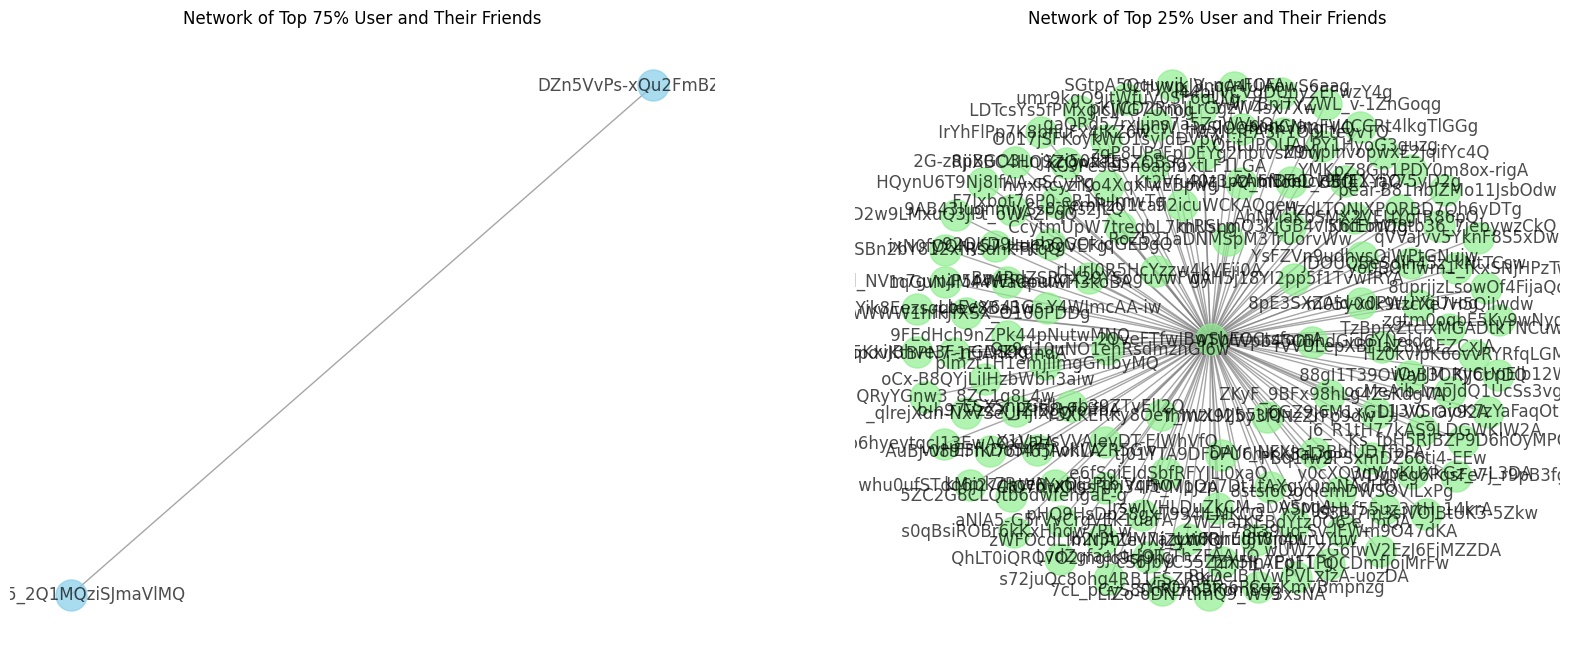

In [ ]:
user_lessFriends = sorted(degrees, key=degrees.get, reverse=True)[-300000]
user_moreFriends = sorted(degrees, key=degrees.get, reverse=True)[300000]
def draw_user_networks_side_by_side(G, user_lessFriends, user_moreFriends):
    # Subgraph for user with less friends (Top 75%)
    friends_less = list(G.neighbors(user_lessFriends))
    subgraph_less = G.subgraph([user_lessFriends] + friends_less)

    # Subgraph for user with more friends (Top 25%)
    friends_more = list(G.neighbors(user_moreFriends))
    subgraph_more = G.subgraph([user_moreFriends] + friends_more)

    # Set up the figure with two subplots
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    nx.draw(subgraph_less, with_labels=True, node_color='skyblue', edge_color='gray',
            node_size=500, font_size=12, alpha=0.7)
    plt.title("Network of Top 75% User and Their Friends")

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    nx.draw(subgraph_more, with_labels=True, node_color='lightgreen', edge_color='gray',
            node_size=500, font_size=12, alpha=0.7)
    plt.title("Network of Top 25% User and Their Friends")
    plt.show()

draw_user_networks_side_by_side(G, user_lessFriends, user_moreFriends)

### Because the original dataset is too large, we sample 10% data and visualize the distribution of friends or fans each user has.

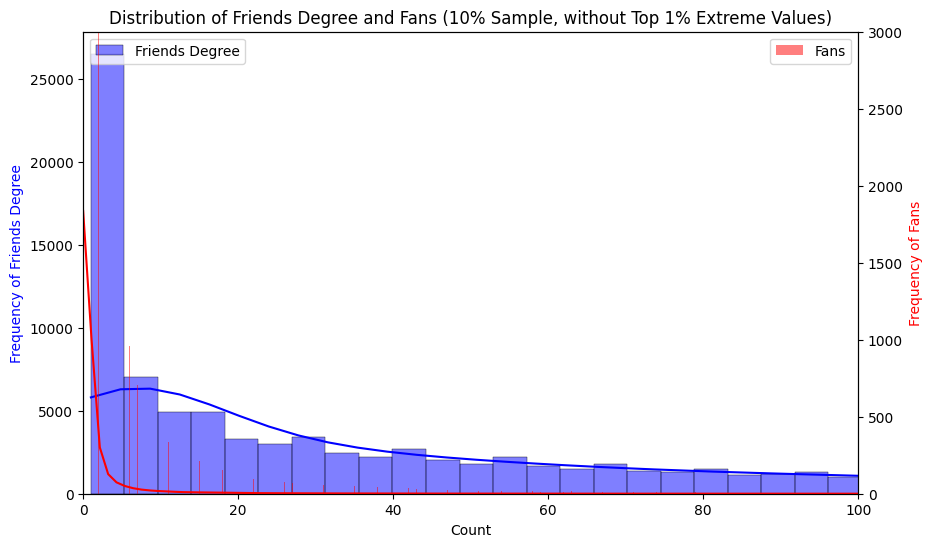

In [8]:
df_sampled = df_users_metric.sample(frac=0.1)
friends_degree_quantile = df_sampled['firends_degree'].quantile(0.99)
fans_quantile = df_sampled['fans'].quantile(0.999)
df_filtered = df_sampled[(df_sampled['firends_degree'] < friends_degree_quantile) &
                         (df_sampled['fans'] < fans_quantile)]


fig, ax1 = plt.subplots(figsize=(10, 6))
sns.histplot(df_filtered['firends_degree'], color="blue", label='Friends Degree', kde=True, alpha=0.5, ax=ax1)

ax2 = ax1.twinx()
sns.histplot(df_filtered['fans'], color="red", label='Fans', kde=True, alpha=0.5, ax=ax2)
ax2.set_ylim(0, 3000)
ax2.set_xlim(0, 100)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Distribution of Friends Degree and Fans (10% Sample, without Top 1% Extreme Values)')
ax1.set_xlabel('Count')
ax1.set_ylabel('Frequency of Friends Degree', color='blue')
ax2.set_ylabel('Frequency of Fans', color='red')
plt.show()


- Both of 'friends_degree' and 'fans' could reflect the social influence of each user.
- From the first picture result, we could see that the user who has more friends could have high level social influence to other, because their soical behaviors they make on Yelp like 'post', 'tag', 'click', 'review' and etc may influence more people.
- Compared to friends degree, the number of friends for users is relatively low, and a very small portion of users have a large number of followers. So this metric may become a good choice for us to pick the users who could come out of from most of users with very limited number of fans with high level social value.

### 2. How long people join Yelp? Does an user joining Yelp early mean high quality?

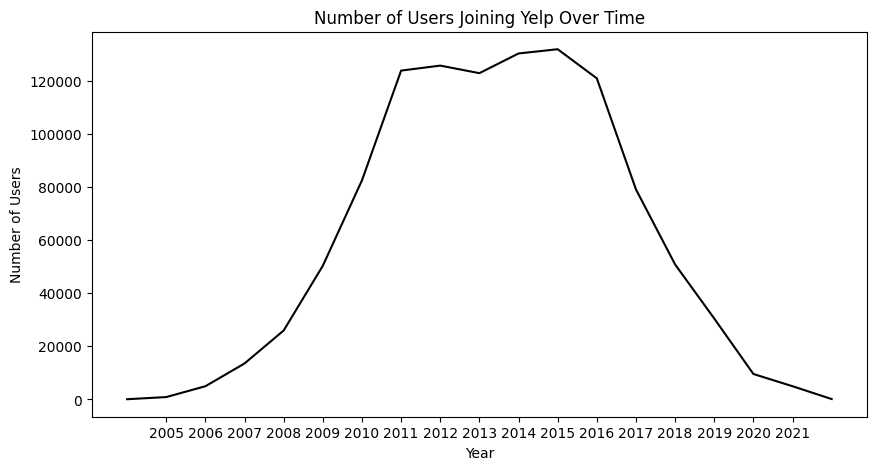

In [ ]:
plt.figure(figsize=(10, 5))
df_users_metric['yelping_since'] = pd.to_datetime(df_users_metric['yelping_since'])
df_users_metric['yelping_since'].dt.year.value_counts().sort_index().plot(kind='line',
                                  color="black")
plt.title('Number of Users Joining Yelp Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Users')
plt.xticks(range(2005, 2022, 1))
plt.show()

- From above picture, we could learn that between 2011 and 2016, there are many new users sign up in Yelp, but it suddenly began to decline in 2017. What factors may cause this phenomenon happen? What Yelp should do to attract more new users to join yelp?
- We could combine the time metric with other metrics, such like fan metric to ccalculate the monthly or annual average growth data as a new metric for us to determine whether a user has high business value.

### 3. What kind of user can be a high quality user to attract more users to his or her post content?

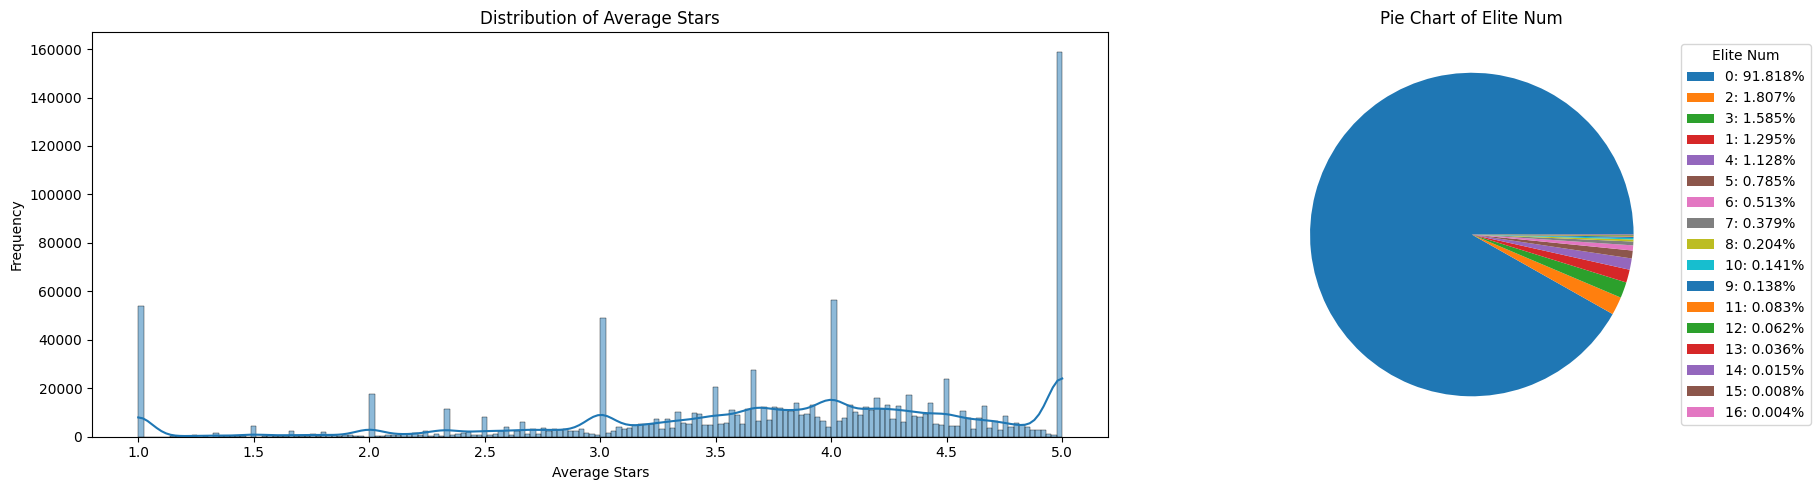

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df_users_metric['average_stars'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Average Stars')
axes[0].set_xlabel('Average Stars')
axes[0].set_ylabel('Frequency')

elite_num_counts = df_users_metric['elite_num'].value_counts()
total = sum(elite_num_counts)
wedges, _ = axes[1].pie(elite_num_counts)
legend_labels = [f'{label}: {count / total:.3%}' for label, count in elite_num_counts.items()]
plt.legend(wedges, legend_labels, title="Elite Num", loc="center left", bbox_to_anchor=(1, 0.5))
axes[1].set_title('Pie Chart of Elite Num')

plt.tight_layout()
plt.show()

- From the picture, the metric of average stars of most users falls in a relatively high range, but only a very small number of users' elite values fall in a high range.
- Compared with average stars for each user' reviews, the elite num could a better metric to determine if a user has good quality performance in Yelp.

### 4. What kind of user can be an active user for Yelp app?

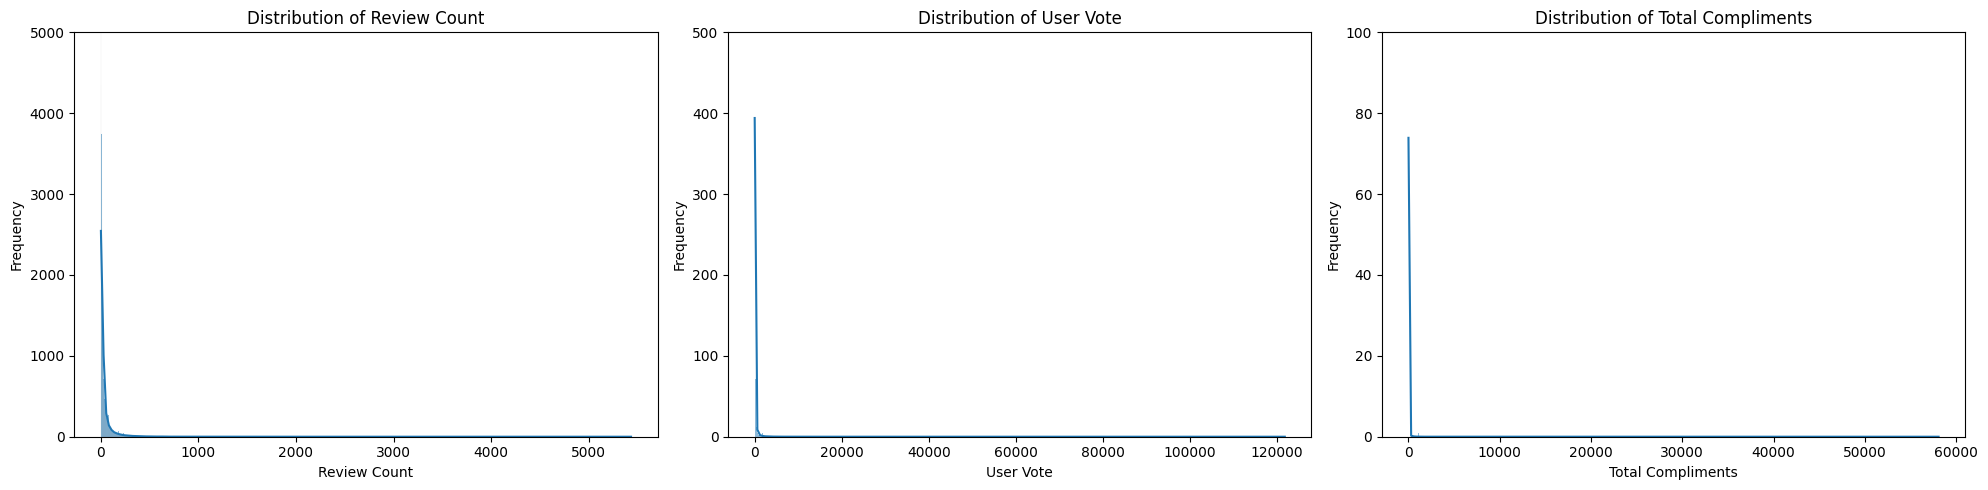

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(df_sampled['review_count'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Review Count')
axes[0].set_xlabel('Review Count')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0, 5000)

sns.histplot(df_sampled['user_vote'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of User Vote')
axes[1].set_xlabel('User Vote')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0, 500)

sns.histplot(df_sampled['total_compliments'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Total Compliments')
axes[2].set_xlabel('Total Compliments')
axes[2].set_ylabel('Frequency')
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [18]:
review_count_des = pd.DataFrame(df_users_metric.review_count.describe()).transpose()
user_vote_des = pd.DataFrame(df_users_metric.user_vote.describe()).transpose()
total_compliments_des = pd.DataFrame(df_users_metric.total_compliments.describe()).transpose()
active_factors_desc = pd.concat([review_count_des, user_vote_des, total_compliments_des])
active_factors_desc

,count,mean,std,min,25%,50%,75%,max
review_count,1109346.0,35.998070,108.103734,0.0,3.0,9.0,28.0,17473.0
user_vote,1109346.0,143.072832,2140.221699,0.0,2.0,9.0,38.0,587933.0
total_compliments,1109346.0,26.429385,732.206651,0.0,0.0,0.0,2.0,324328.0


- From above information, these three metrics also could be good candidate metrics to pick the most active users because the distribution of these three images is extremely uneven, only a very small number of users are at an active level.

## Ⅲ. Design Metrics

Original Metrics
- fans: the number of fans an user has.
- firends_degree: the number of friends an user has.
- review_count: the number of reviews an user wrote.
- user_vote: the number of votes to others an user sent.
- total_compliments: the number of feedback an user received.
- average_stars: the average number of reviews star for each user.
- elite_num: the number of years an user became an elite user.
- join_years: the number of years an user join Yelp.

一个具有高商业价值的用户，需要在多个方面有异于其他用户的优势。比如一个用户有很多粉丝或者好友但很少在Yelp上活跃，或者他发的内容很少有其他户关注，最后不能带来很多商业价值。按照以上情况，我们需要设计多个维度的指标去筛选高商业价值的用户。\

作品热度：
1. works_popularity = total_compliments / review_count:
结合每位用户的评论总数和来自其他用户的反馈数，设计了一个metric，即用户被反馈数/用户评论总数； \
这个metric越高越好，越高代表着这个用户评论有吸引热点的潜力

社交影响：
2. social_influence = fans + friends_degree: \
拥有一定规模粉丝和好友数的用户具备一定能力将他发表的内容传播在Yelp的社区

涨粉潜力：
3. annual_fan_growth_rate = (fans + friends_degree) / join_years: \
用每位用户年度涨粉速率来衡量这个用户吸引其他用户的价值

用户质量：
4. elite_annual_coefficient = elite_num / join_years:
用每位用户精英年份数占总加入Yelp年份的比例来衡量这个用户是否可以作为Yelp的一个高质量用户
5. average_star:
用户发出的评论的平均得分可以作为一个用来衡量其发表内容质量的指标

用户活跃：
6. user_vote:
一个用户在Yelp社群的对其他用户行为的投票数据可以作为衡量一个用户在社群是否活跃的指标。之后我们会在后续建议Yelp采取更多的Metrics进行拥有高质量商业价值用户的筛选。


In [49]:
df_users_metric['works_popularity'] = df_users_metric.total_compliments/df_users_metric.review_count
df_users_metric['social_influence'] = df_users_metric.fans + df_users_metric.friends_degree
df_users_metric['annual_fan_growth_rate'] = round((df_users_metric.fans + df_users_metric.friends_degree)/df_users_metric.join_years, 0)
df_users_metric['elite_annual_coefficient'] = round(df_users_metric.elite_num / df_users_metric.join_years, 1)

#### See the public level of each metrics

In [50]:
df_users_finalMetrics = df_users_metric[['user_id','name','works_popularity', 'social_influence', 'annual_fan_growth_rate', 'elite_annual_coefficient', 'average_stars', 'user_vote']]
final_metrics_desc = pd.concat([pd.DataFrame(df_users_finalMetrics.works_popularity.describe()).transpose(),
                  pd.DataFrame(df_users_finalMetrics.social_influence.describe()).transpose(),
                 pd.DataFrame(df_users_finalMetrics.annual_fan_growth_rate.describe()).transpose(),
                 pd.DataFrame(df_users_finalMetrics.elite_annual_coefficient.describe()).transpose(),
                 pd.DataFrame(df_users_finalMetrics.average_stars.describe()).transpose(),
                 pd.DataFrame(df_users_finalMetrics.user_vote.describe()).transpose()])
final_metrics_desc

,count,mean,std,min,25%,50%,75%,max
works_popularity,1109326.0,inf,NaN,0.0,0.00,0.00,0.117647,inf
social_influence,1109346.0,97.600326,199.640925,1.0,7.00,37.00,116.000000,18198.0
annual_fan_growth_rate,1109346.0,NaN,NaN,-inf,1.00,5.00,17.000000,inf
elite_annual_coefficient,1109320.0,0.034887,0.139560,0.0,0.00,0.00,0.000000,5.3
average_stars,1109346.0,3.760424,1.018982,1.0,3.29,3.95,4.500000,5.0
user_vote,1109346.0,143.072832,2140.221699,0.0,2.00,9.00,38.000000,587933.0


#### Because each metric has different dimensions, it is necessary to standardize data.

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = ['works_popularity', 'social_influence', 'annual_fan_growth_rate',
                        'elite_annual_coefficient', 'average_stars', 'user_vote']
# Handle infinite values
infinite_values = df_users_finalMetrics[columns_to_normalize].isin([np.inf, -np.inf]).any()
if infinite_values.any():
    df_users_finalMetrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle large values
large_values = (df_users_finalMetrics[columns_to_normalize] > 1e9).any()
if large_values.any():
    df_users_finalMetrics[columns_to_normalize] = df_users_finalMetrics[columns_to_normalize].mask(df_users_finalMetrics[columns_to_normalize] > 1e9)

# Normalize the data
normalized_array = scaler.fit_transform(df_users_finalMetrics[columns_to_normalize])

# Convert the normalized array back into a DataFrame
df_normalized = pd.DataFrame(normalized_array, columns=columns_to_normalize)
df_normalized.columns = ['works_popularity_normalized', 'social_influence_normalized',
              'annual_fan_growth_rate_normalized', 'elite_annual_coefficient_normalized',
              'average_stars_normalized', 'user_vote_normalized']
# Concatenate with the 'user_id' and 'name' columns
df_users_finalMetrics_normalized = pd.concat([df_users_finalMetrics.reset_index(drop=True), df_normalized], axis = 1)

# Checking the results
df_users_finalMetrics_normalized.head()

,user_id,name,works_popularity,social_influence,annual_fan_growth_rate,elite_annual_coefficient,average_stars,user_vote,composite_FinalScore,works_popularity_normalized,social_influence_normalized,annual_fan_growth_rate_normalized,elite_annual_coefficient_normalized,average_stars_normalized,user_vote_normalized
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,4.911111,15456,1035.0,0.1,3.91,14470,3366.247273,0.002551,0.849316,0.423832,0.018868,0.7275,0.024612
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4.761366,7805,604.0,1.0,3.74,83438,1797.336972,0.002473,0.428862,0.383551,0.188679,0.6850,0.141918
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,0.879699,434,32.0,0.4,3.32,4099,99.675065,0.000457,0.023795,0.330093,0.075472,0.5800,0.006972
3,SZDeASXq7o05mMNLshsdIA,Gwen,0.607143,159,10.0,0.2,4.27,1141,36.261051,0.000315,0.008683,0.328037,0.037736,0.8175,0.001941
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,0.050633,29,2.0,0.0,3.54,51,6.892888,0.000026,0.001539,0.327290,0.000000,0.6350,0.000087


We devised a way to calculate the final score and select 1,000 commercially valuable users. The specific principle is as follows: we assign different weights to the final candidate metrics, weight and sum all metrics of each user to get the final score, and select the top 1000 users with the final score from high to low as the final result.

$$ CompositeFinalScore = w_1 * WorksPopularity + w_2 * SocialInfluence + \
              w_3 * AnnualFanGrowthRate + w_4 * EliteAnnualCoefficient + \
              w_5 * AverageStars + w_6 * UserVote
$$

 - Each metric is normalized;
 - The six weights are 0.2, 0.3, 0.25, 0.1, 0.1, 0.05


The rationale for setting these six weights is to prioritize social influence and potential for gaining followers as our most important indicators. These two metrics are decisive in determining whether a user can have a widespread impact in the Yelp community. As long as a user has a significant level of influence, the content they post is likely to generate buzz and will touch upon the other metrics we're interested in subsequently.

Next, we focus on the popularity of the user's posts. If a user, while having a vast social reach, also publishes controversial and popular content, the business impact of such a user can be substantial.

Following these, we consider the quality of the posts and the user's own active behavior. These latter two factors, in comparison to the earlier ones, are of lesser importance in terms of the business influence, which is our primary focus. Rather than the quality of the posts, we prefer that a user's content generates buzz. It's truly a case of 'all publicity is good publicity,' even if it's for notoriety.

In [47]:
weights_normalized = {
    'works_popularity_normalized': 0.2,
    'social_influence_normalized': 0.3,
    'annual_fan_growth_rate_normalized': 0.25,
    'elite_annual_coefficient_normalized': 0.1,
    'average_stars_normalized': 0.1,
    'user_vote_normalized': 0.05
}
df_users_finalMetrics_normalized['composite_FinalScore'] = df_users_finalMetrics_normalized.apply(
    lambda x: sum([x[col] * weight for col, weight in weights_normalized.items()]), axis=1)
df_users_finalMetrics_normalized_sorted = df_users_finalMetrics_normalized.sort_values(by='composite_FinalScore', ascending=False)
df_users_finalMetrics_normalized_sorted.head(1000)

,user_id,name,works_popularity,social_influence,annual_fan_growth_rate,elite_annual_coefficient,average_stars,user_vote,composite_FinalScore,works_popularity_normalized,social_influence_normalized,annual_fan_growth_rate_normalized,elite_annual_coefficient_normalized,average_stars_normalized,user_vote_normalized
5444,37cpUoM8hlkSQfReIEBd-Q,Mike,3.294899,18198,1435.0,0.8,4.39,49175,0.519672,0.001712,1.000000,0.461215,0.150943,0.8475,0.083640
139789,iLjMdZi0Tm7DQxX1C1_2dg,Ruggy,11.100657,15089,1046.0,1.0,3.98,89458,0.457088,0.005767,0.829148,0.424860,0.188679,0.7450,0.152157
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,4.911111,15456,1035.0,0.1,3.91,14470,0.437130,0.002551,0.849316,0.423832,0.018868,0.7275,0.024612
141769,JjXuiru1_ONzDkYVrHN0aw,Richard,227.758427,10497,850.0,0.9,4.18,486573,0.436199,0.118316,0.576798,0.406542,0.169811,0.7950,0.827599
139871,hizGc5W1tBHPghM5YKCAtg,Katie,27.294247,13097,1039.0,1.0,4.23,120536,0.434660,0.014179,0.719679,0.424206,0.188679,0.8075,0.205017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705621,nlT_aq3y9KLep0RFMPG5NA,Michael,0.185185,1985,195.0,0.0,4.74,27,0.212562,0.000096,0.109029,0.345327,0.000000,0.9350,0.000046
382644,_jLXrx6aCT9A0ZSHCj7nxg,Yuri,19.801075,2107,183.0,0.6,4.08,16551,0.212557,0.010286,0.115733,0.344206,0.113208,0.7700,0.028151
807480,2P1Eg42DuJYucCE4LJDzeQ,Adam,0.200000,1662,143.0,0.0,5.00,18,0.212523,0.000104,0.091279,0.340467,0.000000,1.0000,0.000031
1037321,yx-IGx7ZI3L8Y0w9NsJtKg,Branden,0.061728,1924,309.0,0.0,4.67,270,0.212478,0.000032,0.105677,0.355981,0.000000,0.9175,0.000459
